# Image generation

In Part 1 of this course, we focused mainly on models that were useful for classification. However, many applications require generating much higher dimensional results, such as images and sentences. Examples include:
* Text: neural translation, text to speech, image captioning
* Image: Segmentation, artistic filters, image sharpening and cleaning

In [1]:
%matplotlib inline
import importlib
import utils2; importlib.reload(utils2)
from utils2 import *

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
from keras import metrics
from keras import layers

from vgg16_avg import VGG16_Avg

Using TensorFlow backend.
/home/jaromir/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Data can be downloaded from [here](http://files.fast.ai/data/imagenet-sample-train.tar.gz). Update path below to where you download data to. Optionally use a 2nd path for fast (e.g. SSD) storage - set both to the same path if using AWS.

In [2]:
path = '/media/jaromir/SATA_2T/Data/Projekty/imagenet/train/'
dpath = '/media/jaromir/SATA_2T/Data/Projekty/fastai/'

## Neural style transfer

The first use case of an image to image architecture we're going to look at is neural style transfer, using the approach in [this paper](https://arxiv.org/abs/1508.06576). This is a fairly popular application of deep learning in which an image is recreated in the style of a work of art, such as Van Gogh's Starry Night. For more information about the use of neural networks in art, see this [Scientific American article](https://blogs.scientificamerican.com/sa-visual/neural-networks-for-artists/) or [Google's Magenta Project](https://magenta.tensorflow.org/welcome-to-magenta).

### Setup

Our first step is to list out the files we have, and then grab some image.

In [14]:
path+'**/*.JPEG'

'/media/jaromir/SATA_2T/Data/Projekty/imagenet/train/**/*.JPEG'

In [15]:
fnames = glob.glob(path+'**/*.JPEG', recursive=True)
n = len(fnames); n

19439

In [16]:
fn = fnames[50]; fn

'/media/jaromir/SATA_2T/Data/Projekty/imagenet/train/n04357314/n04357314_11056.JPEG'

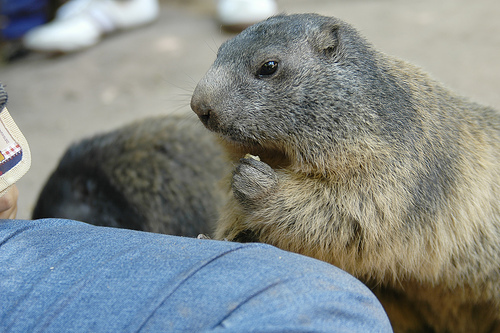

In [17]:
img=Image.open(fnames[1550]); img

That's a nice looking image! Feel free to use any other image that you're interested in playing with.

We'll be using this image with VGG16. Therefore, we need to subtract the mean of each channel of the imagenet data and reverse the order of RGB->BGR since those are the preprocessing steps that the VGG authors did - so their model won't work unless we do the same thing.

We can do this in one step using *broadcasting*, which is a topic we'll be returning to many times during this course.

In [18]:
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]

When we generate images from this network, we'll need to undo the above preprocessing in order to view them.

In [19]:
deproc = lambda x,s: np.clip(x.reshape(s)[:, :, :, ::-1] + rn_mean, 0, 255)

In [20]:
img_arr = preproc(np.expand_dims(np.array(img), 0))
shp = img_arr.shape

In [21]:
shp

(1, 333, 500, 3)

In [12]:
np.array(img).shape

(333, 500, 3)

#### Broadcasting examples

In [13]:
np.array([1,2,3]) - 2

array([-1,  0,  1])

In [14]:
np.array([2,3]).reshape(1,1,1,2)

array([[[[2, 3]]]])

In [15]:
np.array([2,3]).reshape(1,1,2,1)

array([[[[2],
         [3]]]])

In [16]:
b = np.random.randn(2)
b

array([ 0.64931343, -0.59545263])

In [17]:
a = np.random.randn(5,1,3,2)
b = np.random.randn(2)
(a-b).shape

(5, 1, 3, 2)

### Recreate input

The first step in style transfer is understanding how to recreate an image from noise based on "content loss", which is the amount of difference between activations in some layer. In earlier layes, content loss is very similar to per-pixel loss, but in later layers it is capturing the "meaning" of a part of an image, rather than the specific details.

To do this, we first take a CNN and pass an image through it. We then pass a "noise image" (i.e. random pixel values) through the same CNN. At some layer, we compare the outputs from it for both images. We then use a MSE to compare the activations of these two outputs. 

The interesting part is that now, instead of updating the parameters of the CNN, we update the pixels of the noisy image. In other words, our goal is to alter the noisy image so as to minimize the difference between the original image's output at some convolutional layer with the output of the noisy image at the same layer.

In order to construct this architecture, we're going to be working with keras.backend, which is an abstraction layer that allows us to target both theano and tensorflow with the same code.

The CNN we'll use is VGG16, but with a twist. Previously we've always used Vgg with max pooling, and this was useful for image classification. It's not as useful in this case however, because max pooling loses information about the original input area. Instead we will use average pooling, as this does not throw away as much information.

In [18]:
model = VGG16_Avg(include_top=False)

Here we're grabbing the activations from near the end of the convolutional model).

In [19]:
layer = model.get_layer('block5_conv1').output

And let's calculate the target activations for this layer:

In [20]:
layer_model = Model(model.input, layer)
targ = K.variable(layer_model.predict(img_arr))

In our implementation, we need to define an object that will allow us to separately access the loss function and gradients of a function, since that is what scikit-learn's optimizers require.

In [21]:
class Evaluator(object):
    def __init__(self, f, shp): self.f, self.shp = f, shp
        
    def loss(self, x):
        loss_, self.grad_values = self.f([x.reshape(self.shp)])
        return loss_.astype(np.float64)

    def grads(self, x): return self.grad_values.flatten().astype(np.float64)

We'll define our loss function to calculate the mean squared error between the two outputs at the specified convolutional layer.

In [22]:
loss = metrics.mse(layer, targ)
grads = K.gradients(loss, model.input)
fn = K.function([model.input], [loss]+grads)
evaluator = Evaluator(fn, shp)

Now we're going to optimize this loss function with a deterministic approach to optimization that uses a line search, which we can implement with sklearn's `fmin_l_bfgs_b` funtionc. 

In [23]:
def solve_image(eval_obj, niter, x):
    for i in range(niter):
        x, min_val, info = fmin_l_bfgs_b(eval_obj.loss, x.flatten(),
                                         fprime=eval_obj.grads, maxfun=20)
        x = np.clip(x, -127,127)
        print('Current loss value:', min_val)
        imsave(f'{path}/results/res_at_iteration_{i}.png', deproc(x.copy(), shp)[0])
    return x

Next we need to generate a random image.

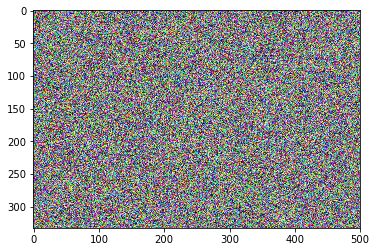

In [28]:
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape)/100
x = rand_img(shp)
plt.imshow(x[0]);

Now we'll run through this optimization approach ten times and train the noise image's pixels as desired.

In [29]:
iterations=10

In [30]:
x = solve_image(evaluator, iterations, x)

Current loss value: [[[ 184.43925476  246.86010742  147.18151855  150.4302063   147.82223511
    141.96640015  156.81292725  170.04060364  158.41990662  165.97520447
    136.93151855  148.71682739  159.60769653  179.43812561  270.36297607
    249.32670593  205.81365967  212.03067017  163.06335449  141.12896729
    131.7819519   121.1370697    99.01432037   95.53274536   99.83496094
    111.75484467  119.83571625  124.3234787   129.6161499   157.27827454
    163.42097473]
  [ 164.24554443  223.03805542  106.85258484  134.21398926  159.41268921
    144.05389404  147.24821472  125.75805664   98.3752594    97.64793396
     94.65663147   99.75083923  117.08756256  212.94973755  305.12930298
    243.36338806  203.11080933  218.384552    245.70285034  186.00108337
    168.84207153  115.01628113   84.63643646   72.34182739   67.25880432
     65.16533661   63.55934525   66.06192017   84.75398254  142.30451965
    128.28143311]
  [ 183.71879578  228.43948364  160.07974243  207.24771118  194.0855

Current loss value: [[[ 120.11222839  181.90151978  107.42427826  107.92435455   97.53310394
     91.30445862  103.04314423  112.54628754   97.67388153  105.96807098
     86.46292877   99.26541138  112.86912537  137.10946655  225.28012085
    196.67132568  155.00871277  154.88269043  116.18991089   93.6262207
     80.55316925   71.21014404   61.07229996   59.32819366   52.56920624
     56.7395668    56.71176147   52.17872238   51.16768646   67.63629913
     67.89260864]
  [ 119.52391815  154.32504272   78.8406601   108.51899719  129.54956055
    115.66073608  116.97914124   94.01005554   58.11650085   56.48844147
     57.84300232   63.13385773   86.27766418  186.96937561  279.1340332
    213.82354736  174.80993652  194.89257812  221.75302124  155.62728882
    135.06098938   84.27812195   59.95837402   51.14682388   41.55447388
     36.36372757   31.4925518    27.18586731   31.33908081   55.9667244
     48.45996094]
  [ 148.19674683  175.18763733  139.08082581  183.71466064  160.1504821

Current loss value: [[[ 110.42706299  169.47158813   98.279953     99.60638428   88.65779877
     81.65733337   93.82707977  102.67796326   86.15298462   94.04868317
     76.05844879   91.37638855  103.60271454  127.32995605  215.38998413
    184.18347168  143.43299866  141.66424561  104.5464325    83.15792084
     71.04109955   61.79615021   53.18837357   51.67446518   43.39582443
     45.02220917   45.96019363   41.95256424   36.21909332   46.49415207
     52.52569199]
  [ 111.42723083  137.86576843   68.47945404  100.34896851  122.99980164
    108.98654175  110.63165283   88.0891037    49.53511047   45.11855316
     48.24302673   53.95820236   77.23867035  179.62860107  271.91125488
    202.05540466  161.41459656  181.76731873  208.29296875  141.83016968
    124.37088776   76.55073547   52.38619232   43.6654892    34.03768158
     28.34936523   23.00696182   18.98375702   19.79603195   35.43209076
     34.87940598]
  [ 140.26062012  162.89797974  131.6541748   177.80587769  153.6478

Current loss value: [[[ 104.81502533  163.13813782   94.72564697   96.0506897    84.08811188
     76.87985229   89.3697052    98.12633514   81.13580322   88.78354645
     71.63774872   87.38464355   99.87290955  123.24604034  210.92837524
    178.24308777  136.88438416  133.65666199   97.85600281   78.35168457
     67.46263885   58.46982956   49.29582596   47.5017128    38.07016373
     38.24734116   39.95060349   37.4041214    31.23365402   38.78451157
     45.35573578]
  [ 106.86682892  131.10307312   65.41864014   97.36510468  120.83116913
    106.23834991  108.07727814   85.12918854   46.20014954   40.53360748
     44.72543716   50.6040535    73.938591    176.49389648  268.22647095
    196.91201782  154.58410645  174.32777405  200.86245728  135.59883118
    120.10456085   73.4325943    49.07355499   39.89358139   30.59895706
     24.6479435    19.93896866   16.46865273   16.91411591   29.07812691
     29.57195854]
  [ 137.07888794  158.17359924  129.62875366  176.31950378  151.5567

Current loss value: [[[ 101.04610443  159.35371399   92.75782776   94.28129578   81.54592896
     73.83855438   86.56051636   95.19090271   77.97431946   85.15736389
     68.90435791   84.957901     97.43356323  120.66531372  208.45967102
    175.23368835  132.9781189   127.00552368   91.68427277   74.37503815
     64.85204315   56.39293671   47.5284462    45.42266464   35.13940048
     34.24200439   36.22693634   34.41171265   28.37493706   34.28998566
     40.82789612]
  [ 103.98886871  127.21746063   63.97390366   95.99324036  119.69184113
    104.66820526  106.44966888   83.45497131   44.22233582   37.38717651
     42.30461121   48.80924606   72.33459473  174.76641846  266.37768555
    194.61732483  149.61373901  167.48446655  193.96495056  129.78990173
    117.42605591   71.97418976   47.32524872   38.11803436   29.14456367
     22.93310547   18.44932938   15.14420033   15.52661514   25.7187748
     26.37093353]
  [ 135.0125885   154.97163391  128.73483276  175.3793335   150.57785

Current loss value: [[[  91.57517242  151.12478638   89.30793762   91.01667023   76.74062347
     68.30740356   80.97377777   88.76823425   71.489151     76.70726776
     62.71349335   79.50004578   91.52692413  115.20309448  203.27700806
    170.66595459  128.34558105  116.91008759   79.8036499    65.32164001
     57.04523468   51.50325012   45.36797333   43.21557999   30.15066338
     27.04023552   28.38379478   27.63873482   22.62465477   25.60935974
     31.50550842]
  [  97.61547852  119.86227417   62.50728226   93.93704224  117.49169159
    101.64037323  103.7300415    80.05426788   40.20571136   31.74254417
     37.13693619   45.92396545   69.74512482  172.00047302  263.92974854
    185.58355713  141.50531006  152.84428406  177.74310303  115.4228363
    106.96156311   68.37158203   43.90457535   35.14070511   27.45925522
     20.77676392   15.78196144   12.76691532   13.18180656   19.49793243
     19.99760818]
  [ 129.63461304  148.99258423  127.68079376  172.65750122  148.57983

Current loss value: [[[  83.5871048   143.12176514   87.34963989   87.7615509    72.6391449
     63.54557419   76.30727386   82.99053955   65.44583893   69.90792847
     58.75082397   75.74403381   87.62313843  111.58476257  198.5188446
    151.59651184  108.09199524  100.38213348   66.25978088   57.85345459
     51.60261536   47.75786591   43.22815704   40.75153351   26.52217484
     22.85457611   22.94562721   22.04211044   17.75580978   19.06096077
     23.75533295]
  [  90.94631958  114.39278412   62.19498444   92.9068985   116.00147247
    100.11369324  101.50105286   77.01956177   36.85282898   28.35616875
     34.91962433   44.51226044   66.62473297  163.73518372  235.60812378
    159.97166443  141.28079224  135.53009033  155.53890991  105.57878113
     99.31511688   63.52706909   40.4921875    32.17016602   25.49949265
     19.41638947   13.93767643   10.93867302   11.19188309   15.2652626
     15.61718082]
  [ 120.54632568  145.92263794  126.41514587  171.20533752  146.4927368

Current loss value: [[[  83.56408691  143.12252808   87.3740387    87.6727066    72.43746948
     63.34469604   76.21585083   82.9883728    65.18947601   69.80133057
     58.78784943   75.77953339   87.61869049  112.1411438   196.59262085
    148.50053406  102.6815033    94.86639404   64.83988953   57.22903824
     51.19900513   47.60710907   43.38720703   40.95024109   26.46860504
     22.74105644   22.9055481    22.00790024   17.75588608   19.05253792
     23.66163254]
  [  90.86009979  114.52867126   62.21509171   92.81105804  115.98988342
    100.01618958  101.45418549   76.92518616   36.78422928   28.21262169
     34.89351654   44.47403717   66.50198364  163.48609924  229.19334412
    152.31164551  133.59761047  133.39761353  154.54920959  105.72569275
     99.01032257   63.53845978   40.60800171   32.32752609   25.39507675
     19.26810074   13.90845871   10.96249866   11.15877724   15.27745438
     15.64829826]
  [ 119.84146118  146.00817871  126.45219421  171.25248718  146.6841

Current loss value: [[[  83.78107452  143.39306641   87.39750671   87.74903107   72.58363342
     63.4667511    76.36116028   83.15969086   65.38642883   70.01501465
     58.91182327   75.90496826   87.70142365  112.08453369  197.50296021
    149.9728241   104.229599     96.23951721   65.06298828   57.28146744
     51.28451538   47.6680603    43.44539642   41.0279541    26.56865311
     22.83939362   23.03317642   22.14468765   17.89783669   19.22149086
     23.85087776]
  [  91.13683319  114.695755     62.16949844   92.84014893  116.03919983
    100.07149506  101.52588654   77.03191376   36.87889862   28.32958412
     34.97127151   44.52139664   66.61335754  163.95870972  231.11886597
    153.83370972  134.32145691  134.19555664  156.05328369  106.16278839
     99.32012939   63.60039139   40.64854431   32.44909668   25.43878365
     19.30213928   13.95290661   11.00873089   11.21006298   15.37944698
     15.76013374]
  [ 120.33105469  146.10623169  126.5243988   171.33642578  146.7593

Current loss value: [[[  83.1131897   142.75622559   87.23675537   87.72658539   72.57605743
     63.45317078   76.35348511   83.1558075    65.38005066   70.01006317
     58.91186523   75.90424347   87.70000458  112.08475494  197.50234985
    149.97213745  104.22930145   96.23949432   65.06297302   57.28145981
     51.28451157   47.6680603    43.44539261   41.02795792   26.56865311
     22.83939171   23.03316879   22.14468765   17.89783096   19.22148132
     23.85086823]
  [  90.71736908  114.52429199   62.15200043   92.86898804  116.03599548
    100.06886292  101.52047729   77.03003693   36.87879181   28.32828522
     34.97105026   44.52138519   66.61351013  163.95690918  231.11616516
    153.83222961  134.32133484  134.19554138  156.05328369  106.16279602
     99.32012177   63.60038376   40.64853668   32.44909668   25.43878174
     19.30213737   13.95290375   11.00872898   11.21006012   15.37944221
     15.76012611]
  [ 120.24134064  146.17745972  126.54660034  171.33703613  146.7598

Our result by comparing output at conv 1 of last block (5) is fairly amorphous, but still easily recognizable as a bird. Notice that the things it has reconstructed particularly well are those things that we expect Vgg16 to be good at recognizing, such as an eye or a beak.

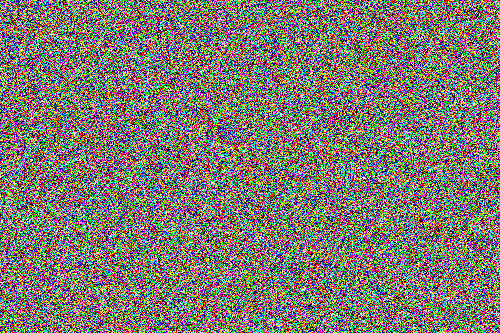

In [31]:
Image.open(path + 'results/res_at_iteration_9.png')

If instead we optimized by calculating loss from the output of conv 1 of 4th block, our trained image looks much more like the original. This makes sense because with less transformations to go through, comparing at an earlier layer means that we have a smaller receptive field and the features are more based on geometric details rather than broad features.

In [ ]:
Image.open(path + 'results/res_at_iteration_9.png')

In [ ]:
from IPython.display import HTML
from matplotlib import animation, rc

In [ ]:
fig, ax = plt.subplots()
def animate(i): ax.imshow(Image.open(f'{path}results/res_at_iteration_{i}.png'))

The optimizer first focuses on the important details of the bird, before trying to match the background.

In [ ]:
anim = animation.FuncAnimation(fig, animate, frames=10, interval=200)
HTML(anim.to_html5_video())

### Recreate style

Now that we've learned how to recreate an input image, we'll move onto attempting to recreate *style*. By "style", we mean the color palette and texture of an image. Unlike recreating based on content, with style we are not concerned about the actual structure of what we're creating, all we care about is that it captures this concept of "style".

Here are some examples of images we can extract style from.

In [ ]:
def plot_arr(arr): plt.imshow(deproc(arr,arr.shape)[0].astype('uint8'))

In [ ]:
style = Image.open('data/starry_night.jpg')
style = style.resize(np.divide(style.size,3.5).astype('int32')); style

In [ ]:
style = Image.open('data/bird.jpg')
style = style.resize(np.divide(style.size,2.4).astype('int32')); style

In [ ]:
style = Image.open('data/simpsons.jpg')
style = style.resize(np.divide(style.size,2.7).astype('int32')); style

We're going to repeat the same approach as before, but with some differences.

In [ ]:
style_arr = preproc(np.expand_dims(style,0)[:,:,:,:3])
shp = style_arr.shape

In [ ]:
model = VGG16_Avg(include_top=False, input_shape=shp[1:])
outputs = {l.name: l.output for l in model.layers}

One thing to notice is that we're actually going to be calculating the loss function multiple layers, rather than just one. (Note however that there's no reason you couldn't try using multiple layers in your content loss function, if you wanted to try that).

In [ ]:
layers = [outputs['block{}_conv1'.format(o)] for o in range(1,3)]

In [ ]:
layers_model = Model(model.input, layers)
targs = [K.variable(o) for o in layers_model.predict(style_arr)]

The key difference is our choice of loss function. Whereas before we were calculating mse of the raw convolutional outputs, here we transform them into the "gramian matrix" of their channels (that is, the product of a matrix and its transpose) before taking their mse. It's unclear why this helps us achieve our goal, but it works. One thought is that the gramian  shows how our features at that convolutional layer correlate, and completely removes all location information. So matching the gram matrix of channels can only match some type of texture information, not location information.

In [ ]:
def gram_matrix(x):
    # We want each row to be a channel, and the columns to be flattened x,y locations
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    # The dot product of this with its transpose shows the correlation 
    # between each pair of channels
    return K.dot(features, K.transpose(features)) / x.get_shape().num_elements()

In [ ]:
def style_loss(x, targ): return metrics.mse(gram_matrix(x), gram_matrix(targ))

In [ ]:
loss = sum(style_loss(l1[0], l2[0]) for l1,l2 in zip(layers, targs))
grads = K.gradients(loss, model.input)
style_fn = K.function([model.input], [loss]+grads)
evaluator = Evaluator(style_fn, shp)

We then solve as we did before.

In [ ]:
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape)/1
x = rand_img(shp)
x = scipy.ndimage.filters.gaussian_filter(x, [0,2,2,0])

In [ ]:
plt.imshow(x[0]);

In [ ]:
iterations=10
x = rand_img(shp)

In [ ]:
x = solve_image(evaluator, iterations, x)

Our results are stunning. By transforming the convolutional outputs to the gramian, we are somehow able to update the noise pixels to produce an image that captures the raw style of the original image, with absolutely no structure or meaning.

In [ ]:
Image.open(path + 'results/res_at_iteration_9.png')

In [ ]:
Image.open(path + 'res_at_iteration_9.png')

### Style transfer

We now know how to reconstruct an image, as well as how to construct an image that captures the style of an original image. The obvious idea may be to just combine these two approaches by weighting and adding the two loss functions.

In [ ]:
w,h = style.size
src = img_arr[:,:h,:w]
plot_arr(src)

Like before, we're going to grab a sequence of layer outputs to compute the style loss. However, we still only need one layer output to compute the content loss. How do we know which layer to grab? As we discussed earlier, the lower the layer, the more exact the content reconstruction will be. In merging content reconstruction with style, we might expect that a looser reconstruction of the content will allow more room for the style to have an effect (re: inspiration). Furthermore, a later layer ensures that the image "looks like" the same subject, even if it doesn't have the same details.

In [ ]:
style_layers = [outputs['block{}_conv2'.format(o)] for o in range(1,6)]
content_name = 'block4_conv2'
content_layer = outputs[content_name]

In [ ]:
style_model = Model(model.input, style_layers)
style_targs = [K.variable(o) for o in style_model.predict(style_arr)]

In [ ]:
content_model = Model(model.input, content_layer)
content_targ = K.variable(content_model.predict(src))

Now to actually merge the two approaches is as simple as merging their respective loss functions. Note that as opposed to our previous to functions, this function is producing three separate types of outputs: one for the original image, one for the image whose style we're emulating, and one for the random image whose pixel's we are training. 

One way for us to tune how the reconstructions mix is by changing the factor on the content loss, which we have here as 1/10. If we increase that denominator, the style will have a larger effect on the image, and if it's too large the original content of the image will be obscured by unstructured style. Likewise, if it is too small than the image will not have enough style.

In [ ]:
style_wgts = [0.05,0.2,0.2,0.25,0.3]

In [ ]:
loss = sum(style_loss(l1[0], l2[0])*w
           for l1,l2,w in zip(style_layers, style_targs, style_wgts))
loss += metrics.mse(content_layer, content_targ)/10
grads = K.gradients(loss, model.input)
transfer_fn = K.function([model.input], [loss]+grads)

In [ ]:
evaluator = Evaluator(transfer_fn, shp)

In [ ]:
iterations=10
x = rand_img(shp)

In [ ]:
x = solve_image(evaluator, iterations, x)

These results are remarkable. Each does a fantastic job at recreating the original image in the style of the artist.

In [ ]:
Image.open(path + 'results/res_at_iteration_9.png')

In [ ]:
Image.open(path + 'res_at_iteration_9.png')

In [ ]:
Image.open(path + 'res_at_iteration_9.png')

There are lots of interesting additional things you could try, such as the ideas shown here: https://github.com/titu1994/Neural-Style-Transfer .

## Use content loss to create a super-resolution network

So far we've demonstrated how to achieve succesful results in style transfer. However, there is an obvious drawback to our implementation, namely that we're training an image, not a network, and therefore every new image requires us to retrain. It's not a feasible method for any sort of real-time application. Fortunately we can adress this issue by using a fully convolutional network (FCN), and in particular we'll look at this implementation for Super resolution. We are following the approach in [this paper](https://arxiv.org/abs/1603.08155).

In [4]:
arr_lr = bcolz.open(dpath+'trn_resized_72_r.bc')[:]
arr_hr = bcolz.open(dpath+'trn_resized_288_r.bc')[:]

In [5]:
parms = {'verbose': 0, 'callbacks': [TQDMNotebookCallback(leave_inner=True)]}

To start we'll define some of the building blocks of our network. In particular recall the residual block (as used in [Resnet](https://arxiv.org/abs/1512.03385)), which is just a sequence of 2 convolutional layers that is added to the initial block input. We also have a de-convolutional layer (also known as a "transposed convolution" or "fractionally strided convolution"), whose purpose is to learn to "undo" the convolutional function. It does this by padding the smaller image in such a way to apply filters on it to produce a larger image.

In [6]:
def conv_block(x, filters, size, stride=(2,2), mode='same', act=True):
    x = Conv2D(filters, (size, size), strides=stride, padding=mode)(x)
    x = BatchNormalization()(x)
    return Activation('relu')(x) if act else x

In [7]:
def res_block(ip, nf=64):
    x = conv_block(ip, nf, 3, (1,1))
    x = conv_block(x, nf, 3, (1,1), act=False)
    return layers.add([x, ip])

In [8]:
def deconv_block(x, filters, size, shape, stride=(2,2)):
    x = Deconvolution2D(filters, (size, size), strides=stride, 
        padding='same', output_shape=(None,)+shape)(x)
    x = BatchNormalization()(x)
    return Activation('relu')(x)

In [11]:
def up_block(x, filters, size):
    x = keras.layers.UpSampling2D()(x)
    x = Conv2D(filters, (size, size), padding='same')(x)
    x = BatchNormalization()(x)
    return Activation('relu')(x)

This model here is using the previously defined blocks to encode a low resolution image and then upsample it to match the same image in high resolution.

In [12]:
inp=Input(arr_lr.shape[1:])
x=conv_block(inp, 64, 9, (1,1))
for i in range(4): x=res_block(x)
x=up_block(x, 64, 3)
x=up_block(x, 64, 3)
x=Convolution2D(3, (9, 9), activation='tanh', padding='same')(x)
outp=Lambda(lambda x: (x+1)*127.5)(x)

The method of training this network is almost exactly the same as training the pixels from our previous implementations. The idea here is we're going to feed two images to Vgg16 and compare their convolutional outputs at some layer. These two images are the target image (which in our case is the same as the original but at higher resolution), and the output of the previous network we just defined, which we hope will learn to output a high resolution image. 

The key then is to train this other network to produce an image that minimizes the loss between the outputs of some convolutional layer in Vgg16 (which the paper refers to as "perceptual loss"). In doing so, we are able to train a network that can upsample an image and recreate the higher resolution details.

In [22]:
vgg_inp=Input(shp)
vgg= VGG16(include_top=False, input_tensor=Lambda(preproc)(vgg_inp))

ValueError: Input 0 is incompatible with layer block1_conv1: expected ndim=4, found ndim=5

Since we only want to learn the "upsampling network", and are just using VGG to calculate the loss function, we set the Vgg layers to not be trainable.

In [ ]:
for l in vgg.layers: l.trainable=False

An important difference in training for super resolution is the loss function. We use what's known as a perceptual loss function (which is simply the content loss for some layer). 

In [ ]:
def get_outp(m, ln): return m.get_layer(f'block{ln}_conv1').output
vgg_content = Model(vgg_inp, [get_outp(vgg, o) for o in [1,2,3]])
vgg1 = vgg_content(vgg_inp)
vgg2 = vgg_content(outp)

In [ ]:
def mean_sqr_b(diff): 
    dims = list(range(1,K.ndim(diff)))
    return K.expand_dims(K.sqrt(K.mean(diff**2, dims)), 0)

In [ ]:
w=[0.1, 0.8, 0.1]
def content_fn(x): 
    res = 0; n=len(w)
    for i in range(n): res += mean_sqr_b(x[i]-x[i+n]) * w[i]
    return res

In [ ]:
m_sr = Model([inp, vgg_inp], Lambda(content_fn)(vgg1+vgg2))
targ = np.zeros((arr_hr.shape[0], 1))

Finally we compile this chain of models and we can pass it the original low resolution image as well as the high resolution to train on. We also define a zero vector as a target parameter, which is a necessary parameter when calling fit on a keras model.

In [ ]:
m_sr.compile('adam', 'mse')
m_sr.fit([arr_lr, arr_hr], targ, 8, 2, **parms)

We use learning rate annealing to get a better fit.

In [ ]:
K.set_value(m_sr.optimizer.lr, 1e-4)
m_sr.fit([arr_lr, arr_hr], targ, 16, 1, **parms)

We are only interested in the trained part of the model, which does the actual upsampling.

In [ ]:
top_model = Model(inp, outp)

In [ ]:
p = top_model.predict(arr_lr[10:11])

After training for some time, we get some very impressive results! Look at these two images, we can see that the predicted higher resolution image has filled in a lot of detail, including the shadows under the greens and the texture of the food.

In [ ]:
plt.imshow(arr_lr[10].astype('uint8'));

In [ ]:
plt.imshow(p[0].astype('uint8'));

In [ ]:
top_model.save_weights(dpath+'sr_final.h5')

In [ ]:
top_model.load_weights(dpath+'top_final.h5')

The important thing to take away here is that as opposed to our earlier approaches, this type of approach results in a model that can created the desired image and is a scalable implementation.

Note that we haven't used a test set here, so we don't know if the above result is due to over-fitting. As part of your homework, you should create a test set, and try to train a model that gets the best result you can on the test set.

## Fast style transfer

The original paper showing the above approach to super resolution also used this approach to create a much faster style transfer system (for a specific style). Take a look at [the paper](https://arxiv.org/abs/1603.08155) and the very helpful [supplementary material](http://cs.stanford.edu/people/jcjohns/papers/eccv16/JohnsonECCV16Supplementary.pdf). Your mission, should you choose to accept it, it to modify the super resolution example above to do fast style transfer based on this paper. 

### Reflection padding

The supplementary material mentions that that found reflection padding helpful - we have implemented this as a keras layer for you. All the other layers and blocks are already defined above.

(This is also a nice simple example of a custom later that you can refer to when creating your own custom layers in the future.)

In [ ]:
class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)
        
    def get_output_shape_for(self, s):
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad,h_pad = self.padding
        return tf.pad(x, [[0,0], [h_pad,h_pad], [w_pad,w_pad], [0,0] ], 'REFLECT')

Testing the reflection padding layer:

In [ ]:
inp = Input((288,288,3))
ref_model = Model(inp, ReflectionPadding2D((40,10))(inp))
ref_model.compile('adam', 'mse')

In [ ]:
p = ref_model.predict(arr_hr[10:11])

In [ ]:
plt.imshow(p[0].astype('uint8'));

### Main algorithm

This approach is exactly the same as super resolution, except now the loss includes the style loss.

In [ ]:
shp = arr_hr.shape[1:]

In [ ]:
style = Image.open('data/starry_night.jpg')
style = style.resize(np.divide(style.size,3.5).astype('int32'))
style = np.array(style)[:shp[0], :shp[1], :shp[2]]
plt.imshow(style);

In [ ]:
def res_crop_block(ip, nf=64):
    x = conv_block(ip, nf, 3, (1,1), 'valid')
    x = conv_block(x,  nf, 3, (1,1), 'valid', False)
    ip = Lambda(lambda x: x[:, 2:-2, 2:-2])(ip)
    return merge([x, ip], mode='sum')

In [ ]:
inp=Input(shp)
x=ReflectionPadding2D((40, 40))(inp)
x=conv_block(x, 64, 9, (1,1))
x=conv_block(x, 64, 3)
x=conv_block(x, 64, 3)
for i in range(5): x=res_crop_block(x)
x=up_block(x, 64, 3)
x=up_block(x, 64, 3)
x=Convolution2D(3, 9, 9, activation='tanh', border_mode='same')(x)
outp=Lambda(lambda x: (x+1)*127.5)(x)

In [ ]:
vgg_inp=Input(shp)
vgg= VGG16(include_top=False, input_tensor=Lambda(preproc)(vgg_inp))
for l in vgg.layers: l.trainable=False

In [ ]:
def get_outp(m, ln): return m.get_layer(f'block{ln}_conv2').output
vgg_content = Model(vgg_inp, [get_outp(vgg, o) for o in [2,3,4,5]])

Here we alter the super resolution approach by adding style outputs

In [ ]:
style_targs = [K.variable(o) for o in
               vgg_content.predict(np.expand_dims(style,0))]

In [ ]:
[K.eval(K.shape(o)) for o in style_targs]

In [ ]:
vgg1 = vgg_content(vgg_inp)
vgg2 = vgg_content(outp)

Our loss now includes the mse for the content loss and the gram matrix for the style

In [ ]:
def gram_matrix_b(x):
    x = K.permute_dimensions(x, (0, 3, 1, 2))
    s = K.shape(x)
    feat = K.reshape(x, (s[0], s[1], s[2]*s[3]))
    return K.batch_dot(feat, K.permute_dimensions(feat, (0, 2, 1))
                      ) / K.prod(K.cast(s[1:], K.floatx()))

In [ ]:
w=[0.1, 0.2, 0.6, 0.1]
def tot_loss(x):
    loss = 0; n = len(style_targs)
    for i in range(n):
        loss += mean_sqr_b(gram_matrix_b(x[i+n]) - gram_matrix_b(style_targs[i])) / 2.
        loss += mean_sqr_b(x[i]-x[i+n]) * w[i]
    return loss

In [ ]:
loss = Lambda(tot_loss)(vgg1+vgg2)
m_style = Model([inp, vgg_inp], loss)
targ = np.zeros((arr_hr.shape[0], 1))

In [ ]:
m_style.compile('adam', 'mae')
m_style.fit([arr_hr, arr_hr], targ, 8, 2, **parms)

In [ ]:
K.set_value(m_style.optimizer.lr, 1e-4)
m_style.fit([arr_hr, arr_hr], targ, 16, 1, **parms)

In [ ]:
top_model = Model(inp, outp)

Now we can pass any image through this CNN and it will produce it in the style desired!

In [ ]:
p = top_model.predict(arr_hr[:20])

In [ ]:
plt.imshow(np.round(p[1]).astype('uint8'));

In [ ]:
top_model.save_weights(dpath+'style_final.h5')

In [ ]:
top_model.load_weights(dpath+'style_final.h5')

## Next steps

Here's some ideas for things to try:
- https://github.com/junyanz/iGAN
- https://arxiv.org/abs/1605.04603
- https://arxiv.org/abs/1606.05897
- http://cs231n.stanford.edu/reports2016/208_Report.pdf